# Data Scientist Assessment Exam
### Problem:

Analyze S&P 500 Index Price Data using statistical tests and forecast future returns using the ARIMA model.

Answer the following using your results:

1. According to the Augmented Dickey-Fuller Test, are the returns stationary ?
2. Assuming that we only choose ARIMA models with p, d, q from 0 to 5, what is the optimal ARIMA order?
3. Using the given dataset, what is tomorrow’s expected return?

### Constraints:

Using S&P 500 Index Price Data, check for stationarity of returns using the Augmented Dickey-Fuller Test and find the optimal ARIMA order to forecast future returns. No other models should be used to analyse the data, and solutions using Python are preferred.

### Solution:

- Clean data by removing all entries with non-numeric values or values equal to ‘0’
- Check for stationarity of returns using the Augmented Dickey-Fuller Test
- Impute missing returns data using KNN algorithm
- Perform a grid-search to find the optimal ARIMA model order by maximising AIC
- Use optimal ARIMA order to fit returns data and forecast returns 1-day ahead

### Download Dataset:

The dataset can be found here: [S&P 500 SPY](https://drive.google.com/drive/folders/1xyw9JAJU0vkhp0Lq0bnNEjdkSLqw_Q4z)

Download this to the same folder as this notebook and run the whole notebook.



In [0]:
# Import Packages

import numpy as np 
import pandas as pd 
from pandas import DataFrame
import matplotlib.pyplot as plt
import itertools
import warnings

# Packages for Time-Series Analysis
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

# Package for Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

# Package for mse
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline

end = '2018'
start = '2015'

In [21]:
# Confirm GPU connection
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# Load data
data = pd.read_csv("Prices.csv", parse_dates=['Ticker']) # Convert Ticker column to datetime

In [23]:
data.head()

Ticker       SPY
0 1997-12-01  68.10944
1 1997-12-02  67.69718
2 1997-12-03  67.89246
3 1997-12-04  67.82737
4 1997-12-05  68.69528

### Exploratory Data Analysis

In [24]:
data.describe()

SPY
count  7339.000000
mean    119.245093
std      48.156079
min      56.588990
25%      86.235160
50%     101.722360
75%     131.259975
max     270.470000

In [25]:
data.dtypes # check if ticker has been converted to datetype and SPY is numeric/float

Ticker    datetime64[ns]
SPY              float64
dtype: object

In [26]:
# Check how many zero values
print (data['SPY'][data['SPY'] == 0])

# Check for null values
print(data['SPY'][data['SPY'].isnull()])

Series([], Name: SPY, dtype: float64)
Series([], Name: SPY, dtype: float64)


### EDA Notes
Since there are no zero or null values, we'll continue with the Time-Series Analysis with the data we have/

In [0]:
data.set_index('Ticker', inplace = True) # Set date (Ticker) as index of dataframe

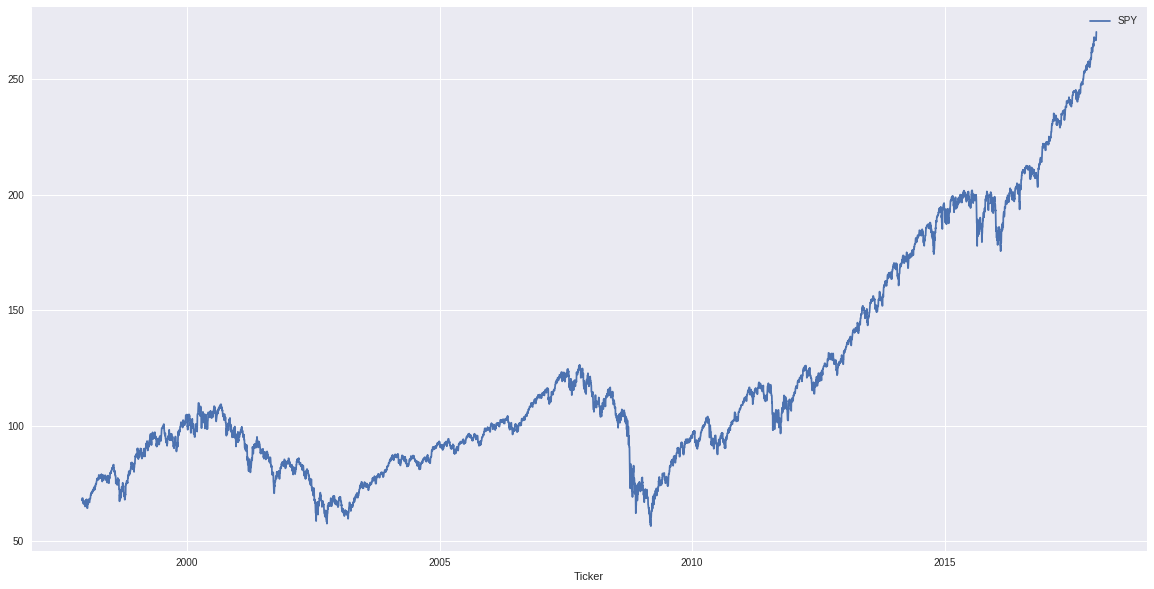

In [28]:
# Plot Daily SPY
data.plot(figsize = (20, 10))

### Plot Insight  

Given the plot of the data, we see that we can do SARIMA forecasting on the data starting 2010 since the trend seems to continue from this starting point. Including more historical data may skew our analysis.


In [0]:
# Use only 2008 - 2018 data
yn = data['SPY'][start:end]

##  Augmented Dickey-Fuller Test  
Are the returns *Stationary*?  

With the assumption that our null hypothesis states that the time-series data is non-stationary, we perform the *augmented Dickey-Fuller Test*

In [11]:
# Perform DF Test
DFtest = adfuller(yn, autolag='AIC') 

DFoutput = pd.Series(DFtest[0:4], index=['test statistic', 'p-value', '#lags Used', 'Num_obs'])

for key, value in DFtest[4].items():
        DFoutput['Critical Value (%s)'%key] = value
    

DFoutput

test statistic             0.542122
p-value                    0.986099
#lags Used                 0.000000
Num_obs                 1098.000000
Critical Value (1%)       -3.436320
Critical Value (5%)       -2.864176
Critical Value (10%)      -2.568173
dtype: float64

### Result

Since the test-statistic value is absolutely higher than the critical value (at any percent), we can't reject the null hypothesis.   
Meaning, the time-series data we have is statistically non-stationary.


## Convert to Stationary

In [12]:
# lets try to make the SPY stationary

tsmlog = np.log10(yn)
tsmlog.dropna(inplace=True)

tsmlogdiff = tsmlog.diff(periods=1)
tsmlogdiff.dropna(inplace=True)

# Stationarity Check
# Perform DF Test
DFtest_ = adfuller(tsmlogdiff, autolag='AIC') 

DFoutput_ = pd.Series(DFtest_[0:4], index=['test statistic', 'p-value', '#lags Used', 'Num_obs'])

for key, value in DFtest_[4].items():
        DFoutput_['Critical Value (%s)'%key] = value
    

DFoutput_

test statistic           -25.077802
p-value                    0.000000
#lags Used                 1.000000
Num_obs                 1096.000000
Critical Value (1%)       -3.436331
Critical Value (5%)       -2.864181
Critical Value (10%)      -2.568176
dtype: float64

### Convert to Stationary Insights

Since we have test-statistic < critical values, then we have converted the time-series into a stationary one.  

Since we see that we can convert the data to stationary through simple shifted differencing, we can grid search on th original time-series data and let *d* handle for the stationarity.

## ACF and PACF Plots  

ACF & PACF graphs are used to visualize AR & MA components.


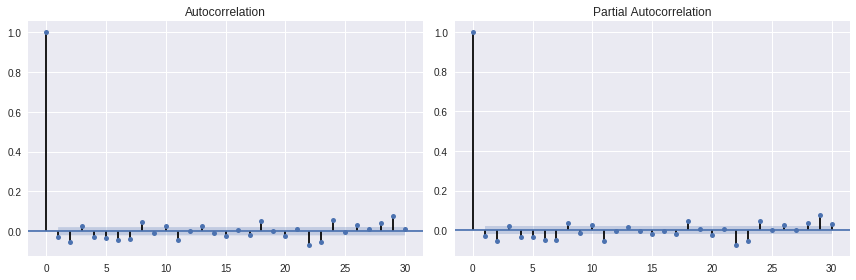

In [13]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(tsmlogdiff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(tsmlogdiff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

## S&P 500 Weekly Averages  
We try to deduce some sort of seasonality in the data by taking the aggregate weekly averages of the S&P 500 returns.

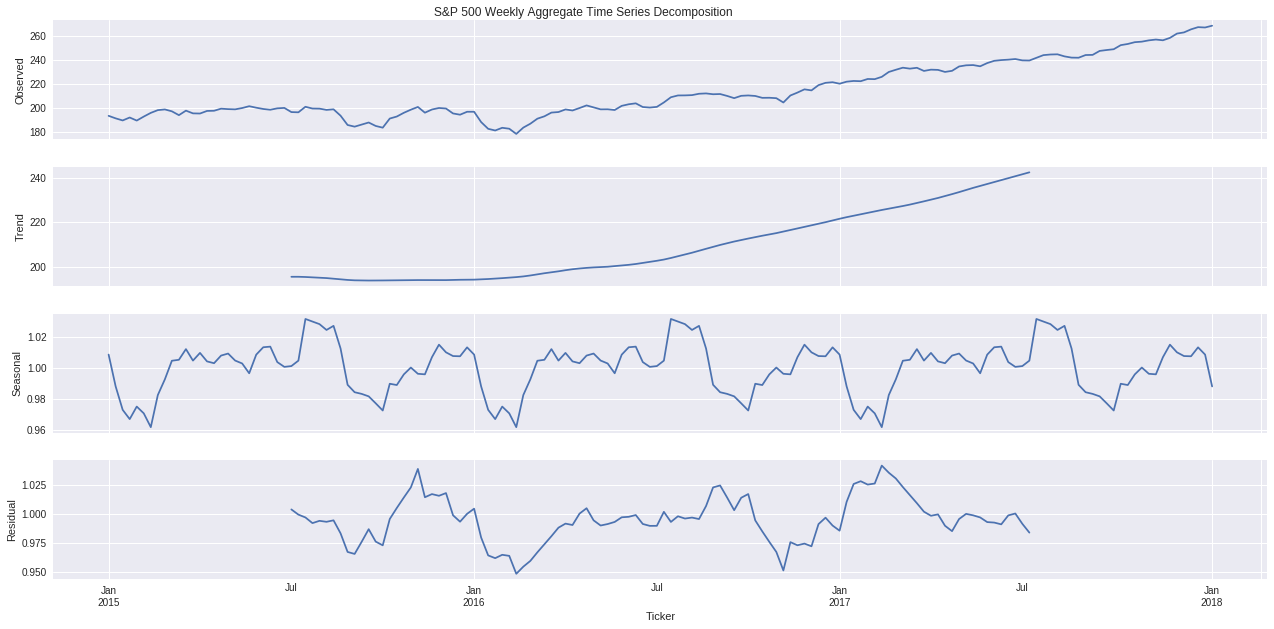

In [14]:
# Decompose trend seasonality resampling data to weekly averages
decomp = sm.tsa.seasonal_decompose(yn.resample('W').mean(), model='multiplicative')

fig = decomp.plot()
fig.set_figwidth(20)
fig.set_figheight(10)
fig.suptitle('S&P 500 Weekly Aggregate Time Series Decomposition')
plt.show()

## S&P 500 Monthly Averages  
We do the same for monthly aggregates to see which one has a better seasonality trend.

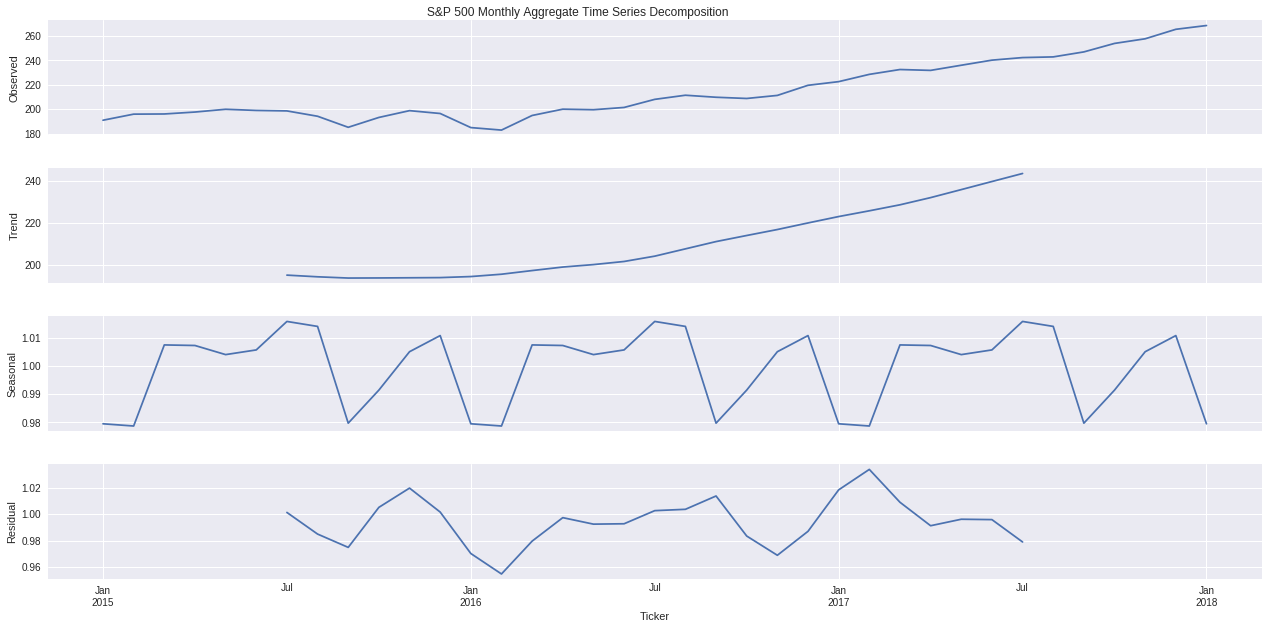

In [15]:
# Decompose trend seasonality resampling data to Monhtly averages
decomp = sm.tsa.seasonal_decompose(yn.resample('M').mean(), model='multiplicative')

fig = decomp.plot()
fig.set_figwidth(20)
fig.set_figheight(10)
fig.suptitle('S&P 500 Monthly Aggregate Time Series Decomposition')
plt.show()

### Resampling Insight  

When we resampled data to weekly averages, we see that the data is seasonal in nature.  But monthly averages output a cleaner seasonality trend. We can then use this to input seasonality of either 52 or 12 as one of the parameters in our search for the best model.

Since we're going to use ARIMA for modelling, we can rely on the grid search of the values *p*, *d*, and *q* (*d* mostly) to turn the data into stationary.

## Grid Search

Search through all possible combinations of *p*, *d*, and *q* as well as the seasonal part.

In [0]:
def standardization(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data-mean)/std, mean, std

def standardization_invert(data, mean, std):
    return data*std + mean

def gridSearch(y, ssn = 12):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], ssn) for x in list(itertools.product(p, d, q))]

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    aic = []
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                ydata, _, _ = standardization(y[start:end])
                mod = sm.tsa.statespace.SARIMAX(ydata,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                aic.append([param, param_seasonal, results.aic])
                print('order={}, seasonality={}, - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic
  
  


In [14]:
%%time

# We forecast from 2015 to 2018.
yn_52 = yn.resample('W').mean()
aic_52 = gridSearch(yn_52, 52)

order=(0, 0, 0), seasonality=(0, 0, 1, 52), - AIC:4744.763740174541
order=(0, 0, 0), seasonality=(1, 0, 0, 52), - AIC:320.5212474039431
order=(0, 0, 0), seasonality=(1, 0, 1, 52), - AIC:314.05526494133295
order=(0, 0, 0), seasonality=(1, 1, 0, 52), - AIC:197.2156489351555
order=(0, 0, 1), seasonality=(0, 0, 0, 52), - AIC:256.9644606526573
order=(0, 0, 1), seasonality=(0, 0, 1, 52), - AIC:5044.363507763302
order=(0, 0, 1), seasonality=(0, 1, 0, 52), - AIC:227.3517372772678
order=(0, 0, 1), seasonality=(1, 0, 0, 52), - AIC:193.3681655246097
order=(0, 0, 1), seasonality=(1, 0, 1, 52), - AIC:189.17442332776068
order=(0, 0, 1), seasonality=(1, 1, 0, 52), - AIC:139.64978066320282
order=(0, 1, 0), seasonality=(0, 0, 1, 52), - AIC:nan
order=(0, 1, 0), seasonality=(1, 0, 0, 52), - AIC:-184.61649492213064
order=(0, 1, 0), seasonality=(1, 0, 1, 52), - AIC:nan
order=(0, 1, 0), seasonality=(1, 1, 0, 52), - AIC:-92.9193978663966
order=(0, 1, 1), seasonality=(0, 0, 0, 52), - AIC:-260.90850542497014
o

In [88]:
sorted_list_52 = sorted(aic_52, key=lambda x:x[2])
sorted_list_52[:20]

[[(1, 1, 0), (0, 0, 0, 52), -263.0295358687589],
 [(1, 0, 1), (0, 0, 0, 52), -261.69222359720663],
 [(0, 1, 1), (0, 0, 0, 52), -260.90850542497014],
 [(1, 0, 0), (0, 0, 0, 52), -258.9980654995303],
 [(1, 1, 1), (0, 0, 0, 52), -258.9562979600638],
 [(1, 1, 0), (1, 0, 1, 52), -215.95775741164923],
 [(0, 1, 1), (1, 0, 1, 52), -214.27503304623272],
 [(1, 1, 1), (1, 0, 1, 52), -214.03152230578087],
 [(1, 1, 0), (1, 0, 0, 52), -208.13064364834517],
 [(1, 1, 1), (1, 0, 0, 52), -207.60055580955128],
 [(1, 0, 1), (1, 0, 1, 52), -197.5103066501514],
 [(1, 0, 1), (1, 0, 0, 52), -192.57678409461502],
 [(0, 1, 1), (1, 0, 0, 52), -192.2786036595593],
 [(1, 0, 0), (1, 0, 1, 52), -189.41949271827207],
 [(1, 0, 0), (1, 0, 0, 52), -186.52473246595434],
 [(0, 1, 0), (1, 0, 0, 52), -184.61649492213064],
 [(1, 1, 0), (1, 1, 0, 52), -105.39612305912335],
 [(1, 1, 1), (1, 1, 0, 52), -104.3039172947855],
 [(1, 0, 1), (1, 1, 0, 52), -97.52556137365711],
 [(0, 1, 1), (1, 1, 0, 52), -96.4216868355307]]

# ARIMA Monthly Aggregate Results

In [63]:
%%time

# We forecast from 2015 to 2018.
yn_12 = data['SPY'].resample('M').mean()
aic_12 = gridSearch(yn_12, 12)

order=(0, 0, 0), seasonality=(0, 0, 1, 12), - AIC:nan
order=(0, 0, 0), seasonality=(1, 0, 0, 12), - AIC:78.4056312046515
order=(0, 0, 0), seasonality=(1, 0, 1, 12), - AIC:nan
order=(0, 0, 0), seasonality=(1, 1, 0, 12), - AIC:48.48674174865161
order=(0, 0, 1), seasonality=(0, 0, 0, 12), - AIC:62.62460675341494
order=(0, 0, 1), seasonality=(0, 0, 1, 12), - AIC:1065.839736545706
order=(0, 0, 1), seasonality=(0, 1, 0, 12), - AIC:53.877399487807274
order=(0, 0, 1), seasonality=(1, 0, 0, 12), - AIC:51.5134461806502
order=(0, 0, 1), seasonality=(1, 0, 1, 12), - AIC:49.869875416144346
order=(0, 0, 1), seasonality=(1, 1, 0, 12), - AIC:37.04577165874256
order=(0, 1, 0), seasonality=(1, 0, 0, 12), - AIC:-4.797598233929113
order=(0, 1, 0), seasonality=(1, 1, 0, 12), - AIC:-2.9006945603642675
order=(0, 1, 1), seasonality=(0, 0, 0, 12), - AIC:-13.167446362817195
order=(0, 1, 1), seasonality=(0, 1, 0, 12), - AIC:-0.6166764495455901
order=(0, 1, 1), seasonality=(1, 0, 0, 12), - AIC:-10.965991740084707

In [85]:
sorted_list = sorted(aic_12, key=lambda x:x[2])
sorted_list[:25]

[[(0, 0, 0), (0, 0, 1, 12), nan],
 [(1, 1, 1), (1, 0, 0, 12), -13.322286150092015],
 [(0, 1, 1), (0, 0, 0, 12), -13.167446362817195],
 [(1, 0, 1), (0, 0, 0, 12), -12.486723190155026],
 [(1, 1, 1), (0, 0, 0, 12), -11.459119136003693],
 [(1, 0, 1), (1, 0, 0, 12), -9.128134540406862],
 [(0, 0, 0), (1, 0, 0, 12), 78.4056312046515],
 [(0, 0, 0), (1, 0, 1, 12), nan],
 [(0, 1, 1), (1, 0, 0, 12), -10.965991740084707],
 [(1, 0, 1), (1, 0, 1, 12), -10.892021407000211],
 [(1, 1, 0), (0, 0, 0, 12), -9.922989333299606],
 [(1, 1, 0), (1, 0, 0, 12), -8.201402613711624],
 [(1, 0, 0), (0, 0, 0, 12), -6.197631142143631],
 [(0, 1, 1), (1, 1, 0, 12), -5.780346595761827],
 [(1, 0, 1), (1, 1, 0, 12), -5.411103596213531],
 [(1, 0, 0), (1, 1, 0, 12), -4.8549816717484084],
 [(0, 1, 0), (1, 0, 0, 12), -4.797598233929113],
 [(1, 0, 0), (1, 0, 0, 12), -4.6535421154679675],
 [(1, 1, 1), (1, 1, 0, 12), -4.044773263928942],
 [(1, 0, 0), (1, 0, 1, 12), -3.086603093074096],
 [(0, 1, 0), (1, 1, 0, 12), -2.9006945603642

### AIC Results  
We take the algebraically lowest AIC.

In [30]:
mod = sm.tsa.statespace.SARIMAX(yn, 
                                order=(1,1,1), 
                                seasonal_order=(1,0,0,12),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                SPY   No. Observations:                 1099
Model:             SARIMAX(1, 1, 1)x(1, 0, 0, 12)   Log Likelihood               -1800.548
Date:                            Tue, 11 Sep 2018   AIC                           3609.095
Time:                                    08:16:04   BIC                           3629.104
Sample:                                01-01-2015   HQIC                          3616.665
                                     - 01-03-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6015      0.198      3.040      0.002       0.214       0.989
ma.L1         -0.6430      0.188   

## Model Diagnostics

The *p-value* of each *coef* is close to zero and hence we include the features in our model.

We run some diagnostics in the model to see if assumptions still hold and/or some trends weren't captured.

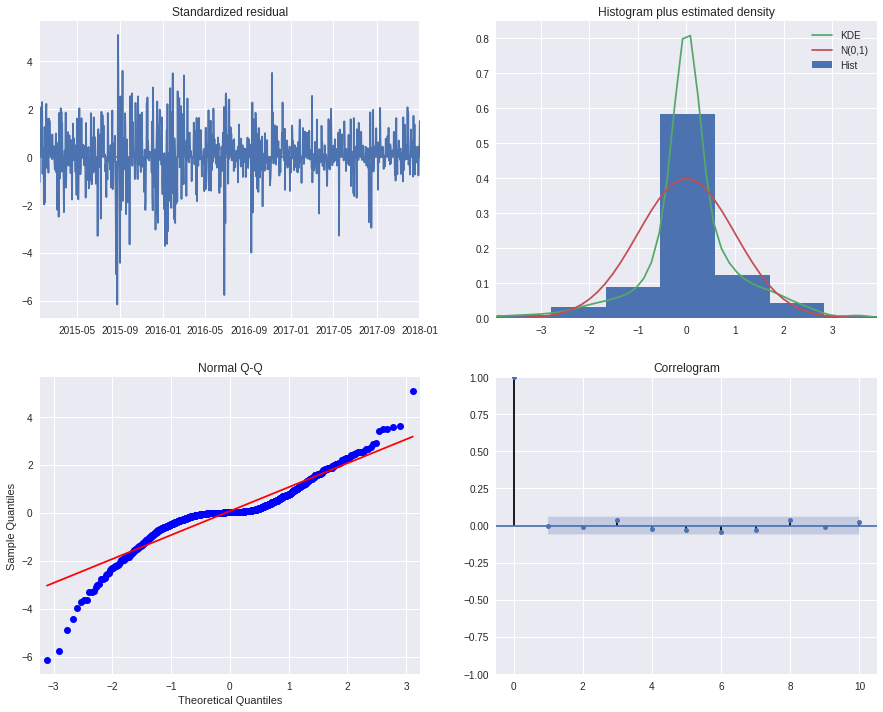

In [31]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## Get Predictions

In [32]:
pred = results.get_prediction(start = '2017-06-01', end = "2018-01-04", dynamic=False)
pred_ci = pred.conf_int()
pred_ci.tail()

lower SPY   upper SPY
2017-12-31  264.385363  269.370811
2018-01-01  264.378840  269.364288
2018-01-02  264.374625  269.360073
2018-01-03  266.202791  271.188240
2018-01-04  267.858824  272.844273

In [33]:
pred.predicted_mean.tail()

2017-12-31    266.878087
2018-01-01    266.871564
2018-01-02    266.867349
2018-01-03    268.695515
2018-01-04    270.351549
Freq: D, dtype: float64

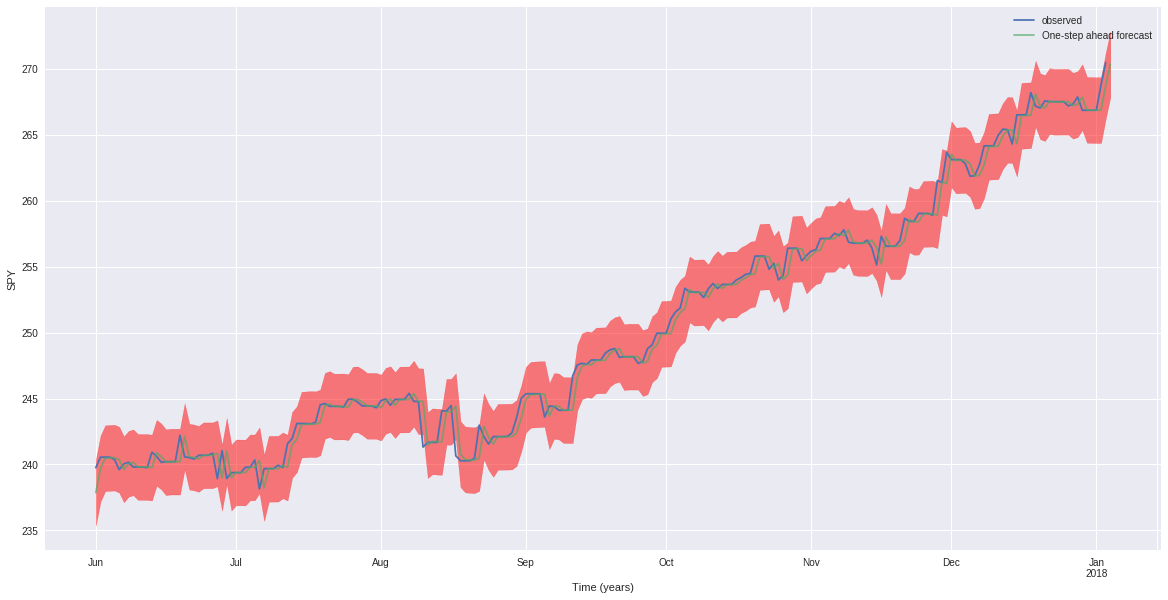

In [36]:
ax = yn['2017-06-01':].plot(label='observed', figsize = (20, 10))
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('SPY')
plt.legend()

plt.show()

In [36]:
# MSE
mse(yn['2017-06-01':], pred.predicted_mean['2017-06-01':'2018-01-03'])

0.7530376495507913

### Answer : Day-Ahead Forecast

These are obtained using monthly aggregates with a **mean square error of 0.753**.

In [19]:
yn['2017-12-01':].tail()

Ticker
2017-12-30    266.86
2017-12-31    266.86
2018-01-01    266.86
2018-01-02    268.77
2018-01-03    270.47
Name: SPY, dtype: float64

In [100]:
pred.predicted_mean.tail()

2017-12-31    266.878087
2018-01-01    266.871564
2018-01-02    266.867349
2018-01-03    268.695515
2018-01-04    270.351549
Freq: D, dtype: float64

### Monthly Aggregate Forecast Insights

We now have day-after foreacasts using monthly aggregates.

# ARIMA Weekly Aggregate Results

Do the same for weekly and compare results.

### AIC Results

In [37]:
mod_w = sm.tsa.statespace.SARIMAX(yn, 
                                order=(1,1,0), 
                                seasonal_order=(0,0,0,52),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_w = mod_w.fit()
print(results_w.summary())

                           Statespace Model Results                           
Dep. Variable:                    SPY   No. Observations:                 1099
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -1827.080
Date:                Tue, 11 Sep 2018   AIC                           3658.161
Time:                        08:19:03   BIC                           3668.165
Sample:                    01-01-2015   HQIC                          3661.946
                         - 01-03-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0316      0.021     -1.525      0.127      -0.072       0.009
sigma2         1.6375      0.037     44.484      0.000       1.565       1.710
Ljung-Box (Q):                       48.07   Jarque-

### Model Diagnostics

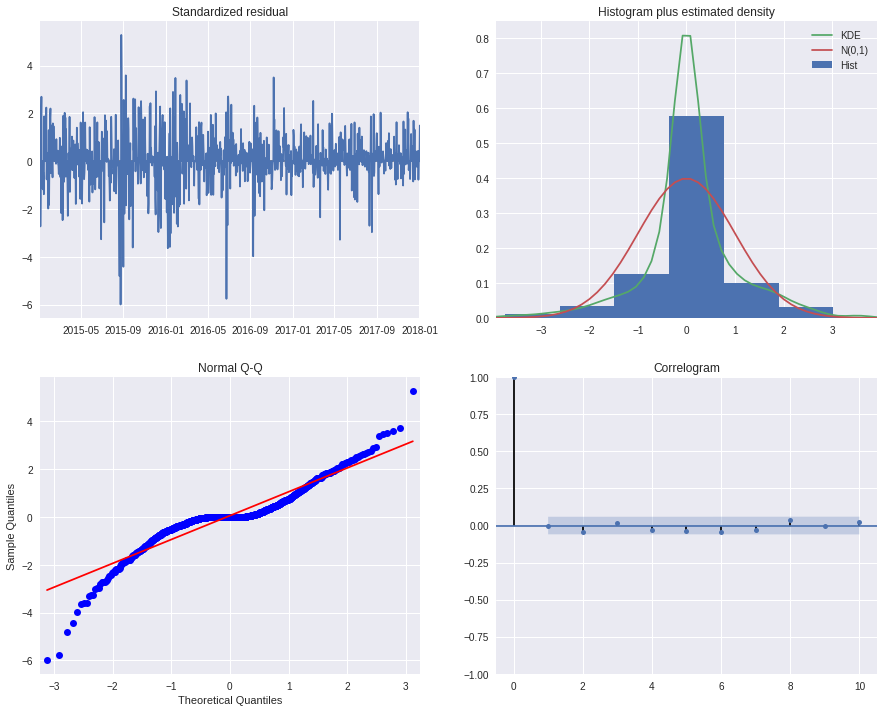

In [38]:
results_w.plot_diagnostics(figsize=(15, 12))
plt.show()

### Get Predictions

In [39]:
pred_w = results_w.get_prediction(start = '2017-06-01', end = "2018-01-04", dynamic=False)
pred_ci_w = pred_w.conf_int()
pred_ci_w.tail()

lower SPY   upper SPY
2017-12-31  264.351934  269.368066
2018-01-01  264.351934  269.368066
2018-01-02  264.351934  269.368066
2018-01-03  266.201546  271.217679
2018-01-04  267.908186  272.924318

In [40]:
# MSE
mse(yn['2017-06-01':], pred_w.predicted_mean['2017-06-01':'2018-01-03'])

0.7525752019957826

### Answer : Day-Ahead Forecast

These are obtained using weekly aggregates with **mean square error of 0.7525**

In [40]:
pred_w.predicted_mean.tail()

2017-12-31    266.860000
2018-01-01    266.860000
2018-01-02    266.860000
2018-01-03    268.709612
2018-01-04    270.416252
Freq: D, dtype: float64

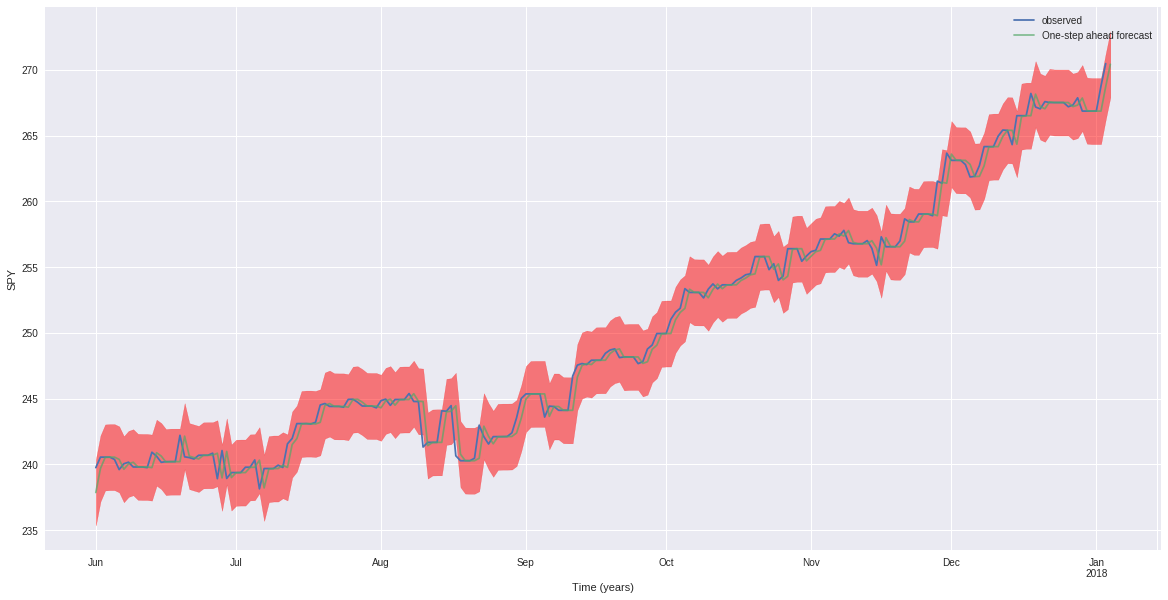

In [41]:
ax = yn['2017-06-01':].plot(label='observed', figsize = (20, 10))
pred_w.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci_w.index,
                pred_ci_w.iloc[:, 0],
                pred_ci_w.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('SPY')
plt.legend()

plt.show()

### Weekly Aggregate Forecast Insights

We now have the day-after forecasts using weekly aggregates.

# ARIMA Daily Forecast

Lastly, let's try brute force grid search on the daily resolution.

### Grid Search 

Get Optimal AIC for daily SPY but only from July 2017 and assuming monthly seasonality. This is so we reduce the dataset to finer resolution but less data.

In [0]:
yn_daily = yn['2017-6-01':]

In [42]:
%%time

# We forecast from December 2017 to 2018.

aic_d = gridSearch(yn_daily, 30)

order=(0, 0, 0), seasonality=(0, 0, 1, 30), - AIC:433.18783086564605
order=(0, 0, 0), seasonality=(0, 1, 1, 30), - AIC:285.96253375525947
order=(0, 0, 0), seasonality=(1, 0, 0, 30), - AIC:340.14407595341527
order=(0, 0, 0), seasonality=(1, 0, 1, 30), - AIC:320.96150673439513
order=(0, 0, 0), seasonality=(1, 1, 0, 30), - AIC:266.4633418023719
order=(0, 0, 0), seasonality=(1, 1, 1, 30), - AIC:205.5586450664386
order=(0, 0, 1), seasonality=(0, 0, 0, 30), - AIC:345.3016532902293
order=(0, 0, 1), seasonality=(0, 0, 1, 30), - AIC:209.41175042098718
order=(0, 0, 1), seasonality=(0, 1, 0, 30), - AIC:135.20767752514786
order=(0, 0, 1), seasonality=(0, 1, 1, 30), - AIC:121.48075835457522
order=(0, 0, 1), seasonality=(1, 0, 0, 30), - AIC:135.51319473463926
order=(0, 0, 1), seasonality=(1, 0, 1, 30), - AIC:126.2395713160357
order=(0, 0, 1), seasonality=(1, 1, 0, 30), - AIC:114.86762029755675
order=(0, 0, 1), seasonality=(1, 1, 1, 30), - AIC:71.21386003846115
order=(0, 1, 0), seasonality=(0, 0, 1, 

In [24]:
sorted(aic_d, key = lambda x: x[2])[:20]

[[(1, 1, 0), (0, 0, 0, 30), -403.4695915596247],
 [(1, 0, 1), (0, 0, 0, 30), -401.85706607682675],
 [(1, 0, 0), (0, 0, 0, 30), -401.4160975852508],
 [(0, 1, 1), (0, 0, 0, 30), -400.09929118469927],
 [(1, 1, 1), (0, 0, 0, 30), -399.10094695749535],
 [(0, 1, 0), (1, 0, 0, 30), -346.2812420907943],
 [(0, 1, 1), (1, 0, 0, 30), -344.9692078534158],
 [(1, 0, 0), (1, 0, 0, 30), -344.7509096454488],
 [(1, 0, 0), (0, 0, 1, 30), -344.37218276041233],
 [(1, 0, 1), (1, 0, 0, 30), -343.6146009865241],
 [(1, 0, 0), (1, 0, 1, 30), -343.51430816531683],
 [(0, 1, 0), (0, 0, 1, 30), -342.99977168990495],
 [(1, 1, 0), (1, 0, 0, 30), -342.1618469435449],
 [(0, 1, 0), (1, 0, 1, 30), -342.0189201584177],
 [(1, 1, 0), (0, 0, 1, 30), -341.79767899002513],
 [(1, 1, 0), (1, 0, 1, 30), -340.8120184255838],
 [(1, 0, 1), (0, 0, 1, 30), -340.41117167070684],
 [(1, 1, 1), (1, 0, 0, 30), -340.37921977767485],
 [(1, 0, 1), (1, 0, 1, 30), -339.6191175771462],
 [(0, 1, 1), (0, 0, 1, 30), -339.0640681436974]]

In [43]:
mod_d = sm.tsa.statespace.SARIMAX(yn_daily, 
                                order=(1,1,0), 
                                seasonal_order=(0,0,0,30),   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_d = mod_d.fit()
print(results_d.summary())

                           Statespace Model Results                           
Dep. Variable:                    SPY   No. Observations:                  217
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -271.286
Date:                Tue, 11 Sep 2018   AIC                            546.571
Time:                        08:21:27   BIC                            553.331
Sample:                    06-01-2017   HQIC                           549.302
                         - 01-03-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1437      0.069     -2.096      0.036      -0.278      -0.009
sigma2         0.7303      0.042     17.480      0.000       0.648       0.812
Ljung-Box (Q):                       37.71   Jarque-

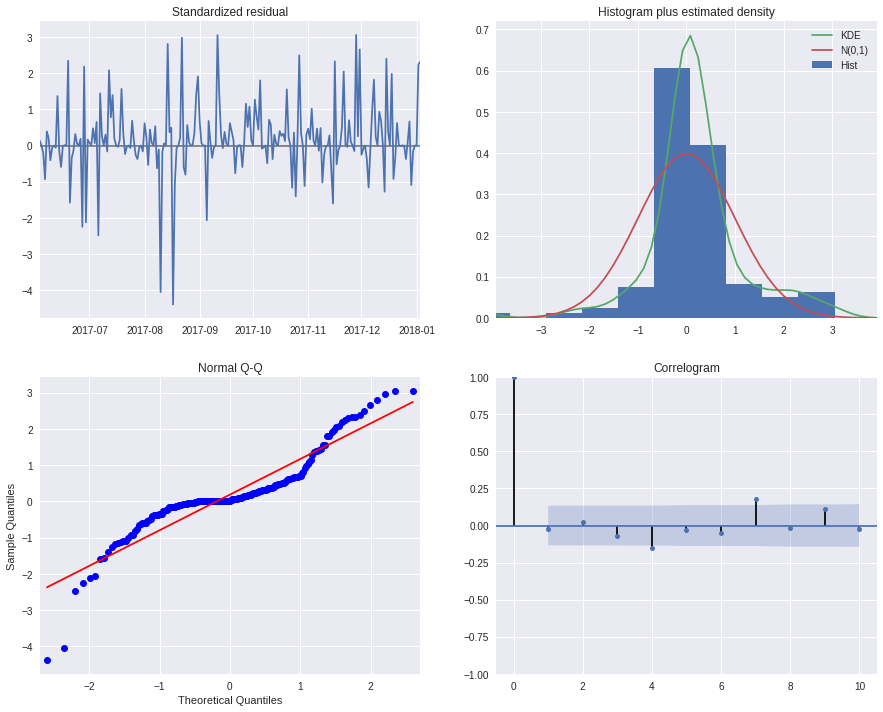

In [44]:
results_d.plot_diagnostics(figsize=(15, 12))
plt.show()

### Get predictions

In [50]:
pred_d = results_d.get_prediction(start = '2017-12-01', end = "2018-01-04", dynamic=False)
pred_ci_d = pred_d.conf_int()
pred_ci_d.tail()

lower SPY   upper SPY
2017-12-31  265.185054  268.534946
2018-01-01  265.185054  268.534946
2018-01-02  265.185054  268.534946
2018-01-03  266.820546  270.170438
2018-01-04  268.550728  271.900620

In [51]:
# MSE
mse(yn['2017-12-01':], pred_d.predicted_mean['2017-12-01':'2018-01-03'])

0.6893356831759437

### Day-Ahead Forecast

These are obtained using daily resolution with a **mean square error of 0.68**.

In [48]:
pred_d.predicted_mean.tail()

2017-12-31    266.860000
2018-01-01    266.860000
2018-01-02    266.860000
2018-01-03    268.495492
2018-01-04    270.225674
Freq: D, dtype: float64

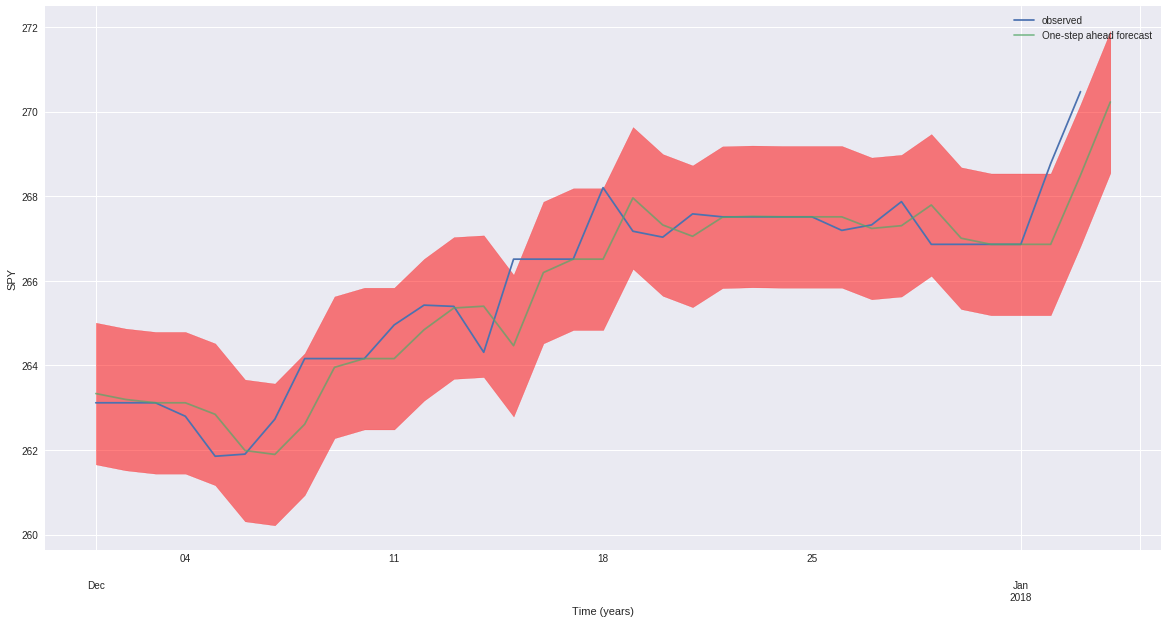

In [49]:
ax = yn['2017-12-01':].plot(label='observed', figsize = (20, 10))
pred_d.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci_d.index,
                pred_ci_d.iloc[:, 0],
                pred_ci_d.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (years)')
ax.set_ylabel('SPY')
plt.legend()

plt.show()

# Conclusion  

We have therefore performed time-series forecasting using daily, weekly, monthly analysis to predict day-ahead figures. The three methods result in fairly similar values differing only in 2 decimal places and all three having **average MSE of around 0.70** where doing time-series analysis and forecasting on a daily resolution with a much closer time horizon provides the lowest **MSE of 0.69**.